Creating Fourier modes:  (150, 150)
Calibration modes required: 2688


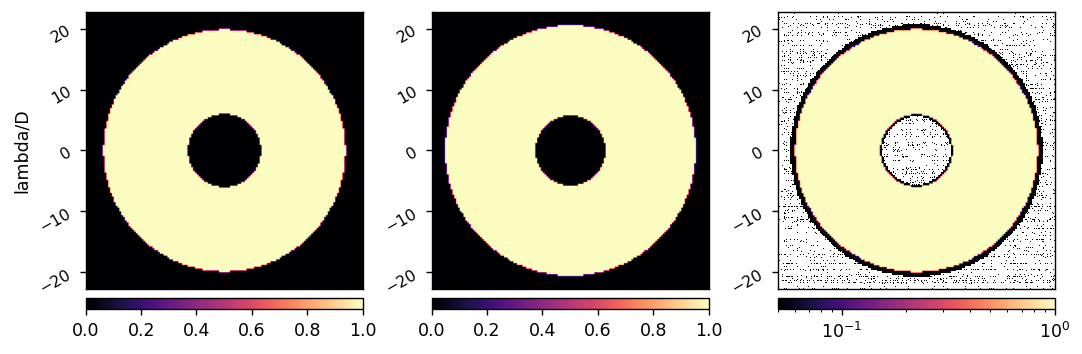

Calibrating I-EFC...
	Calibrated mode 1 / 2688 in 5.807s
	Calibrated mode 2 / 2688 in 11.582s
Calibration interrupted.
Calibration complete.
Saved data to:  /groups/douglase/kians-data-files/roman-cgi-iefc-data/response-data/spc_wide_2dm_annular_6to20
Saved data to:  /groups/douglase/kians-data-files/roman-cgi-iefc-data/calibration-data/spc_wide_2dm_annular_6to20


In [7]:
import spc_wide_iefc_calibration

In [1]:
import numpy as np
import cupy as cp
import astropy.units as u
from astropy.io import fits
from matplotlib.patches import Rectangle, Circle
from pathlib import Path
from IPython.display import clear_output
from importlib import reload

import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('INFO')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

poppy_log.disabled = True

import warnings
warnings.filterwarnings("ignore")

import cgi_phasec_poppy as cgi
from cgi_phasec_poppy import misc

from wfsc import iefc_2dm as iefc
from wfsc import utils

# import misc

dm1_flat = 2*fits.getdata(cgi.data_dir/'dm-acts'/'flatmaps'/'hlc_flattened_dm1.fits')
dm2_flat = 2*fits.getdata(cgi.data_dir/'dm-acts'/'flatmaps'/'hlc_flattened_dm2.fits')

# dm1_flat = fits.getdata(cgi.dm_dir/'flatmaps'/'hlc_flattened_with_pattern_dm1.fits')
# dm2_flat = fits.getdata(cgi.dm_dir/'flatmaps'/'hlc_flattened_with_pattern_dm2.fits')

INFO:numexpr.utils:Note: detected 96 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 96 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.


In [3]:
cgi.__file__

'/home/u21/kianmilani/src/cgi-phasec-poppy/cgi_phasec_poppy/__init__.py'

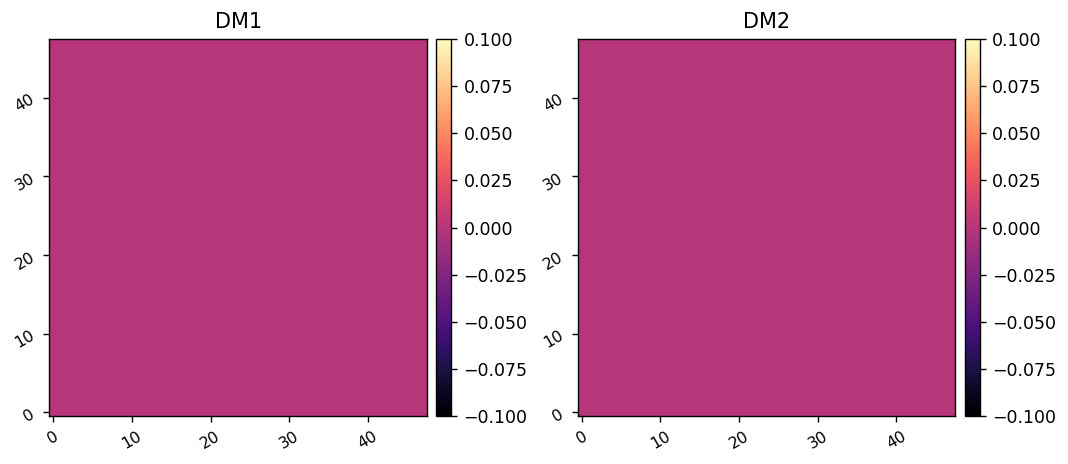

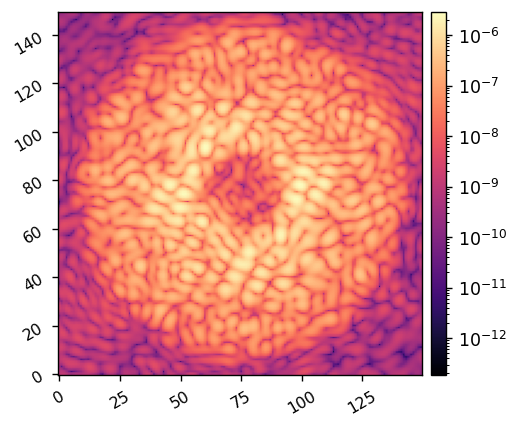

In [2]:
reload(cgi)
sys = cgi.CGI(cgi_mode='spc-wide', npsf=150,
              use_fpm=True,
              use_pupil_defocus=True, 
              polaxis=0,
              use_opds=True,
#               dm1_ref=dm1_flat, dm2_ref=dm2_flat,
             )
sys.show_dms()

npsf = sys.npsf
Nact = sys.Nact

ref_psf = sys.snap()

misc.myimshow(ref_psf, lognorm=True)

# Create dark hole ROI to calibrate and control

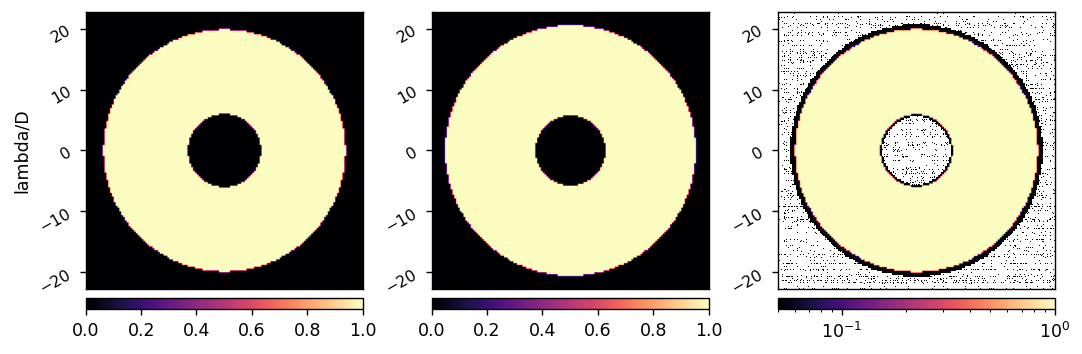

In [4]:
reload(utils)
xfp = np.linspace(-0.5, 0.5, npsf) * npsf * sys.psf_pixelscale_lamD
xf,yf = np.meshgrid(xfp,xfp)

edge = 1
iwa = 6
owa = 20
rot = 0

# Create the mask that is used to select which region to make dark.
dh_params = {
    'inner_radius' : iwa,
    'outer_radius' : owa,
    'edge_position' : edge,
    'direction' : '+x',
    'rotation':rot,
    'full':True,
}
dh_mask = utils.create_annular_focal_plane_mask(xf, yf, dh_params).ravel()

#Create the mask that is used to select which region to make dark.
control_params = {
    'inner_radius' : iwa-0.2,
    'outer_radius' : owa+0.7,
    'edge_position' : edge,
    'rotation':rot,
    'full':True,
}
control_mask = utils.create_annular_focal_plane_mask(xf, yf, control_params).ravel()

relative_weight = 0.95
weights = dh_mask * relative_weight + (1 - relative_weight) * control_mask

misc.myimshow3(dh_mask.reshape(npsf,npsf),
               control_mask.reshape(npsf,npsf), 
               weights.reshape(npsf,npsf),
               lognorm3=True,
               pxscl1=sys.psf_pixelscale_lamD, pxscl2=sys.psf_pixelscale_lamD, pxscl3=sys.psf_pixelscale_lamD)

# Create probe and fourier modes

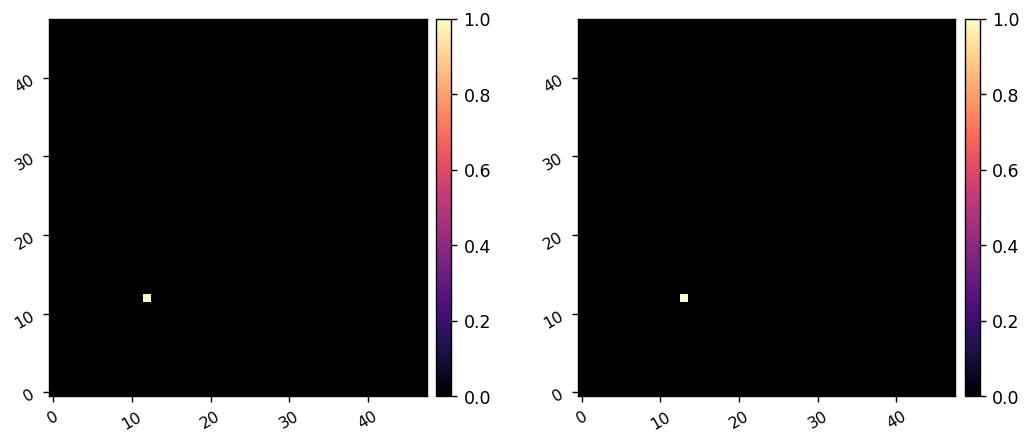

Creating Fourier modes:  (150, 150)
Calibration modes required: 2688


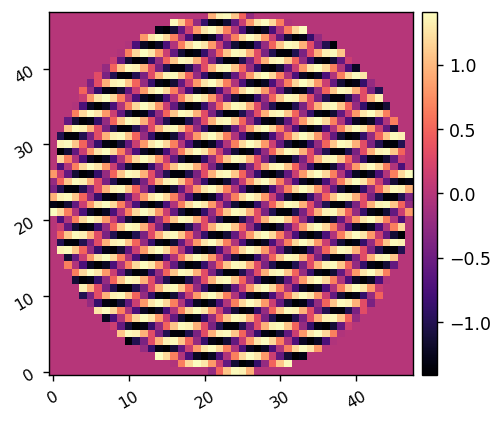

In [5]:
reload(iefc)
probe_modes = iefc.create_probe_poke_modes(Nact, 
                                           xinds=[Nact//4, Nact//4+1],
                                           yinds=[Nact//4, Nact//4], 
                                           display=True)

calibration_modes, fx, fy = iefc.create_fourier_modes(xfp, 
                                                      control_mask.reshape((npsf,npsf)), 
                                                      Nact, 
                                                      circular_mask=False)
calibration_modes[:] *= sys.dm_mask.flatten()

nmodes = calibration_modes.shape[0]
print('Calibration modes required: {:d}'.format(nmodes))
misc.myimshow(calibration_modes[0].reshape(Nact,Nact))

calibration_amplitude = 0.006 * sys.wavelength_c.to(u.m).value
probe_amplitude = 0.05 * sys.wavelength_c.to(u.m).value

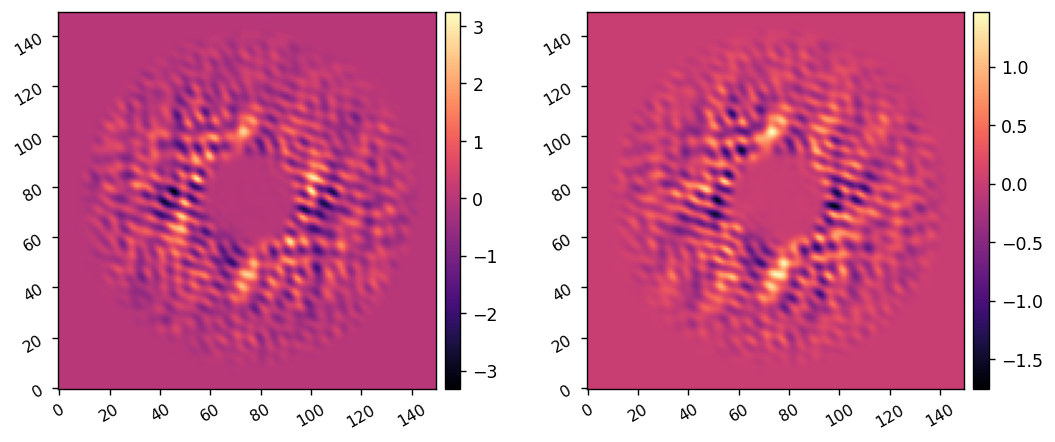

In [43]:
reload(iefc)
sys.reset_dms()
differential_images, single_images = iefc.take_measurement(sys, 
                                                           probe_modes, probe_amplitude, 
                                                           return_all=True, display=True)

# Calibrate IEFC (or load in previous calibration data)

In [23]:
reload(iefc)
response_cube, calibration_cube = iefc.calibrate(sys, probe_amplitude, probe_modes, 
                                                 calibration_amplitude, calibration_modes, start_mode=0)

Calibrating I-EFC...
	Calibrated mode 1 / 592 in 5.761s
	Calibrated mode 2 / 592 in 11.517s
	Calibrated mode 3 / 592 in 17.392s
	Calibrated mode 4 / 592 in 23.151s
	Calibrated mode 5 / 592 in 28.919s
	Calibrated mode 6 / 592 in 34.690s
	Calibrated mode 7 / 592 in 40.464s
	Calibrated mode 8 / 592 in 46.232s
	Calibrated mode 9 / 592 in 51.996s
	Calibrated mode 10 / 592 in 57.775s
	Calibrated mode 11 / 592 in 63.637s
	Calibrated mode 12 / 592 in 69.405s
	Calibrated mode 13 / 592 in 75.174s
	Calibrated mode 14 / 592 in 80.941s
	Calibrated mode 15 / 592 in 86.709s
	Calibrated mode 16 / 592 in 92.471s
	Calibrated mode 17 / 592 in 98.239s
	Calibrated mode 18 / 592 in 104.005s
	Calibrated mode 19 / 592 in 109.850s
	Calibrated mode 20 / 592 in 115.619s
	Calibrated mode 21 / 592 in 121.383s
	Calibrated mode 22 / 592 in 127.152s
	Calibrated mode 23 / 592 in 132.922s
	Calibrated mode 24 / 592 in 138.687s
	Calibrated mode 25 / 592 in 144.458s
	Calibrated mode 26 / 592 in 150.227s
	Calibrated mode 2

	Calibrated mode 213 / 592 in 1231.412s
	Calibrated mode 214 / 592 in 1237.186s
	Calibrated mode 215 / 592 in 1242.967s
	Calibrated mode 216 / 592 in 1248.741s
	Calibrated mode 217 / 592 in 1254.516s
	Calibrated mode 218 / 592 in 1260.298s
	Calibrated mode 219 / 592 in 1266.078s
	Calibrated mode 220 / 592 in 1271.858s
	Calibrated mode 221 / 592 in 1277.722s
	Calibrated mode 222 / 592 in 1283.495s
	Calibrated mode 223 / 592 in 1289.271s
	Calibrated mode 224 / 592 in 1295.051s
	Calibrated mode 225 / 592 in 1300.824s
	Calibrated mode 226 / 592 in 1306.593s
	Calibrated mode 227 / 592 in 1312.370s
	Calibrated mode 228 / 592 in 1318.149s
	Calibrated mode 229 / 592 in 1324.009s
	Calibrated mode 230 / 592 in 1329.781s
	Calibrated mode 231 / 592 in 1335.559s
	Calibrated mode 232 / 592 in 1341.332s
	Calibrated mode 233 / 592 in 1347.111s
	Calibrated mode 234 / 592 in 1352.890s
	Calibrated mode 235 / 592 in 1358.677s
	Calibrated mode 236 / 592 in 1364.451s
	Calibrated mode 237 / 592 in 1370.303s


	Calibrated mode 418 / 592 in 2418.844s
	Calibrated mode 419 / 592 in 2424.627s
	Calibrated mode 420 / 592 in 2430.416s
	Calibrated mode 421 / 592 in 2436.206s
	Calibrated mode 422 / 592 in 2442.082s
	Calibrated mode 423 / 592 in 2447.873s
	Calibrated mode 424 / 592 in 2453.660s
	Calibrated mode 425 / 592 in 2459.444s
	Calibrated mode 426 / 592 in 2465.231s
	Calibrated mode 427 / 592 in 2471.015s
	Calibrated mode 428 / 592 in 2476.800s
	Calibrated mode 429 / 592 in 2482.591s
	Calibrated mode 430 / 592 in 2488.456s
	Calibrated mode 431 / 592 in 2494.241s
	Calibrated mode 432 / 592 in 2500.021s
	Calibrated mode 433 / 592 in 2505.812s
	Calibrated mode 434 / 592 in 2511.596s
	Calibrated mode 435 / 592 in 2517.393s
	Calibrated mode 436 / 592 in 2523.191s
	Calibrated mode 437 / 592 in 2528.979s
	Calibrated mode 438 / 592 in 2534.845s
	Calibrated mode 439 / 592 in 2540.633s
	Calibrated mode 440 / 592 in 2546.430s
	Calibrated mode 441 / 592 in 2552.216s
	Calibrated mode 442 / 592 in 2558.006s


In [6]:
fname = 'spc_wide_2dm_full_6to10'
fname = 'spc_wide_2dm_annular_6to20'
iefc_dir = Path('/groups/douglase/kians-data-files/roman-cgi-iefc-data')

In [29]:
misc.save_pickle(iefc_dir/'response-data'/fname, response_cube)
misc.save_pickle(iefc_dir/'calibration-data'/fname, calibration_cube)

Saved data to:  /groups/douglase/kians-data-files/roman-cgi-iefc-data/response-data/spc_wide_2dm_full_6to10
Saved data to:  /groups/douglase/kians-data-files/roman-cgi-iefc-data/calibration-data/spc_wide_2dm_full_6to10


In [7]:
response_cube = misc.load_pickle(iefc_dir/'response-data'/fname)
calibration_cube = misc.load_pickle(iefc_dir/'calibration-data'/fname)

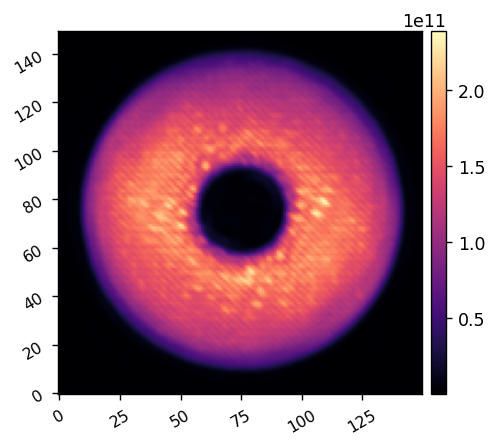

In [8]:
response_sum = np.sum(abs(response_cube), axis=(0,1))
misc.myimshow(response_sum.reshape(150,150))

# Create control matrix

In [9]:
reload(iefc)
# OPTIONAL: Filter the calibration files by subtracting PCA modes
# npca = 3
# filtered_response_cube, pca_modes = iefc.remove_k_pca_modes(response_cube, k=npca)

control_matrix = iefc.construct_control_matrix(response_cube, 
                                               weights.flatten(), 
                                               rcond1=5e-3,
                                               rcond2=5e-3,
                                               WLS=True,
                                               nprobes=probe_modes.shape[0],
                                               pca_modes=None)

Using Weighted Least Squares 


In [10]:
control_matrix.shape

(5376, 26680)

# Run IEFC

Running I-EFC...
	Closed-loop iteration 1 / 20


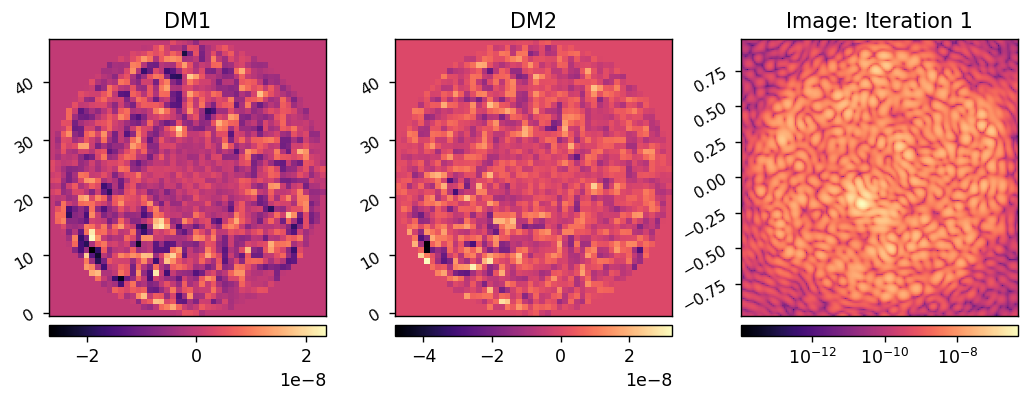

	Closed-loop iteration 2 / 20


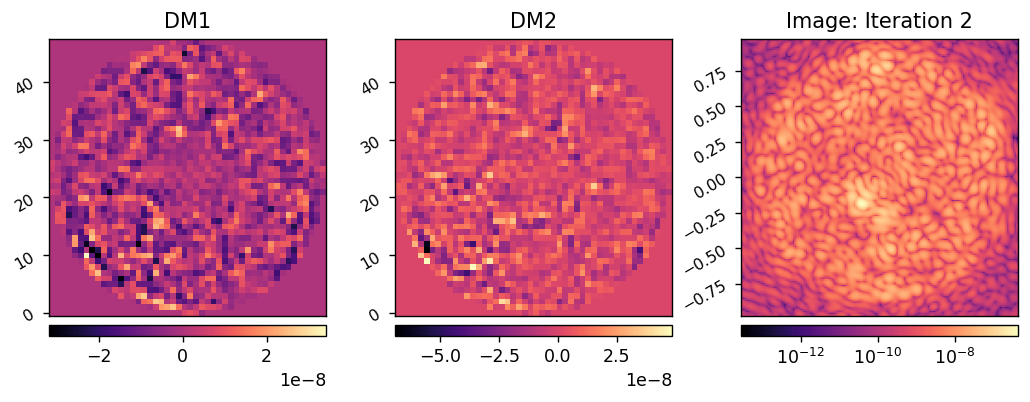

	Closed-loop iteration 3 / 20


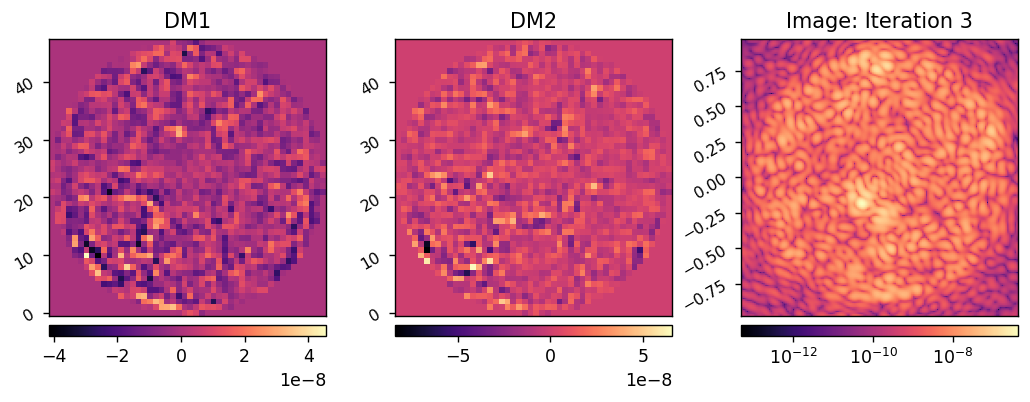

	Closed-loop iteration 4 / 20


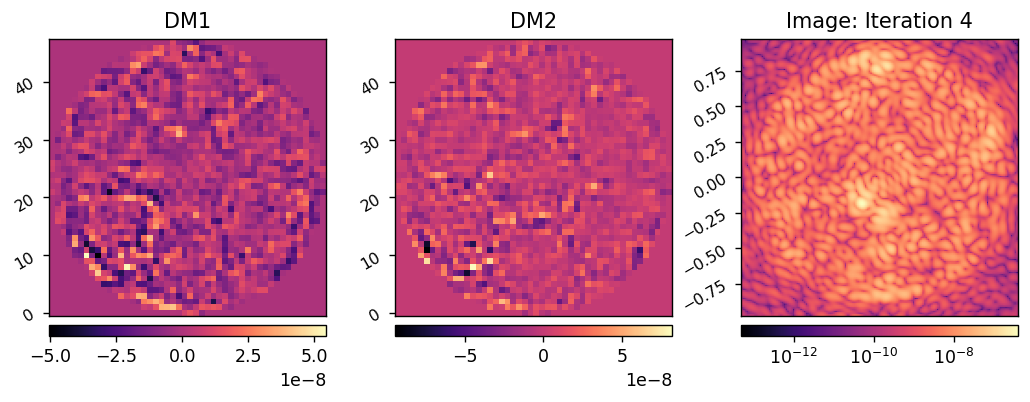

	Closed-loop iteration 5 / 20


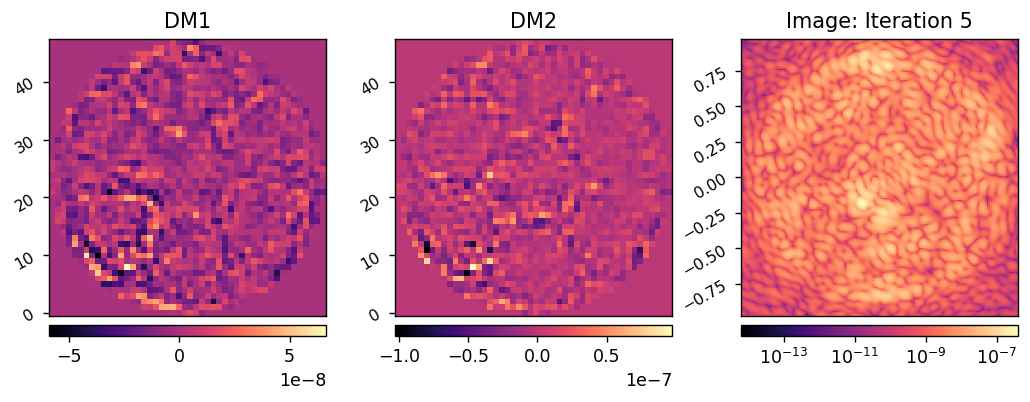

	Closed-loop iteration 6 / 20


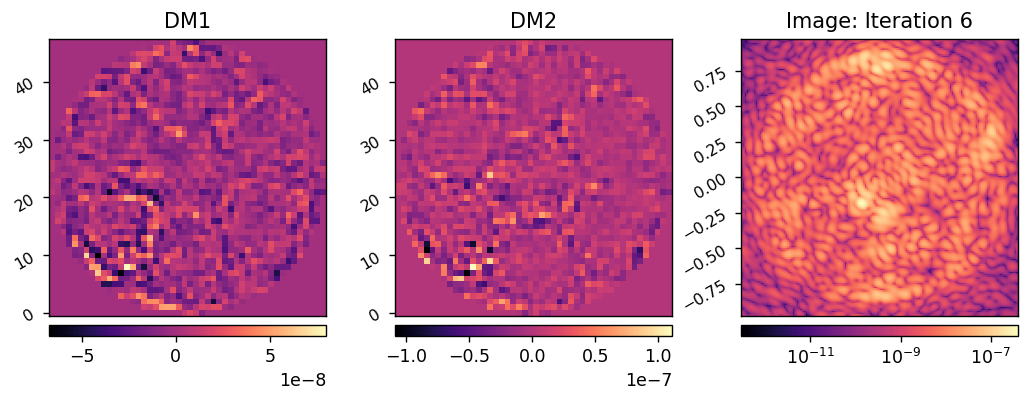

	Closed-loop iteration 7 / 20


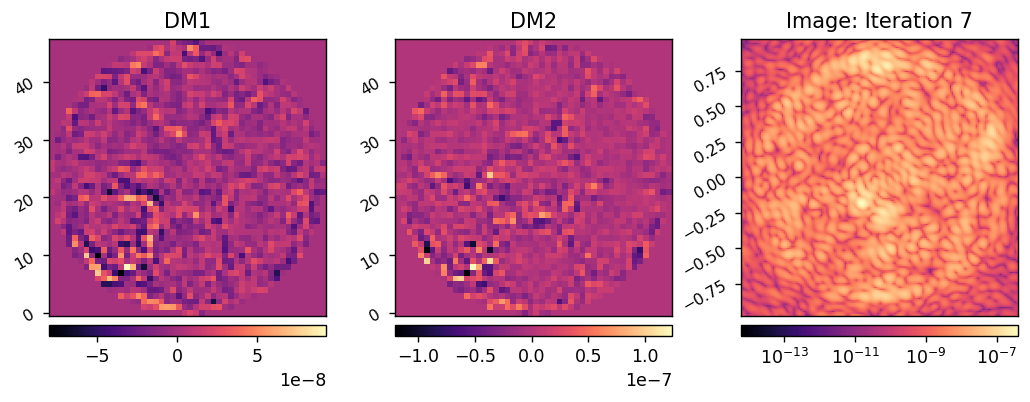

	Closed-loop iteration 8 / 20


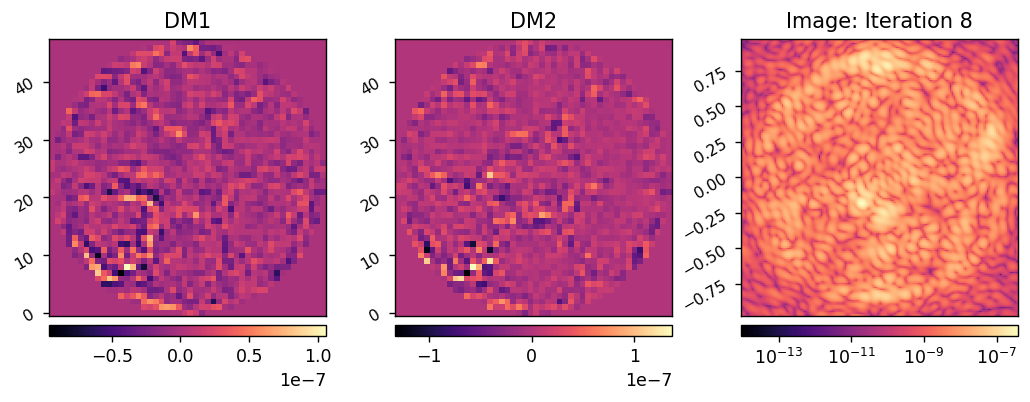

	Closed-loop iteration 9 / 20


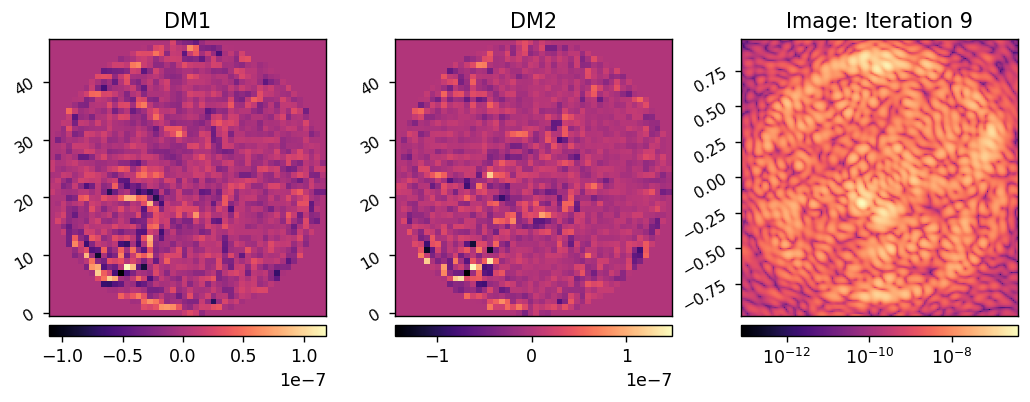

	Closed-loop iteration 10 / 20


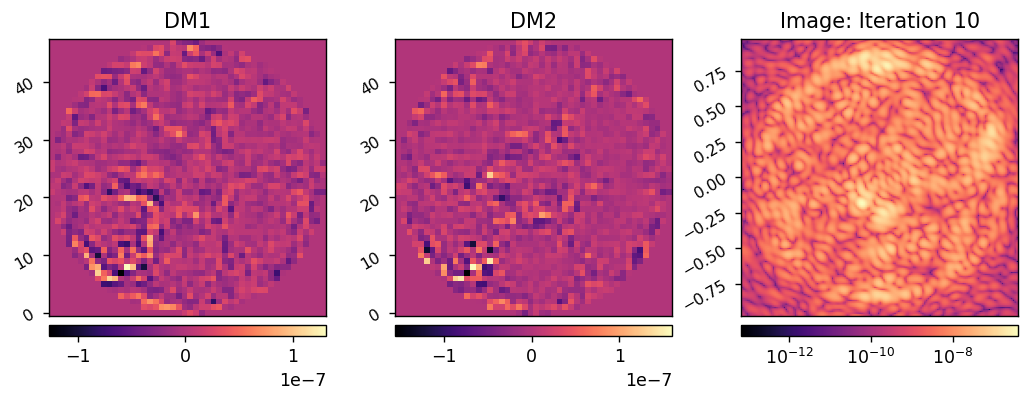

	Closed-loop iteration 11 / 20


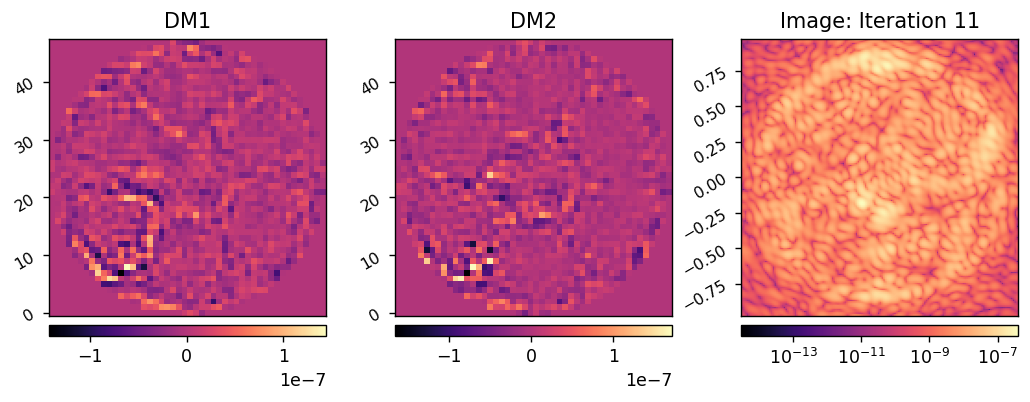

	Closed-loop iteration 12 / 20


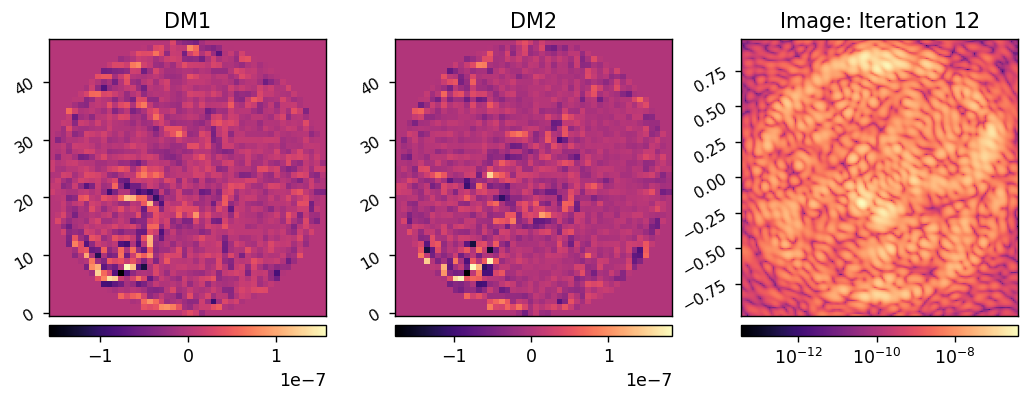

	Closed-loop iteration 13 / 20


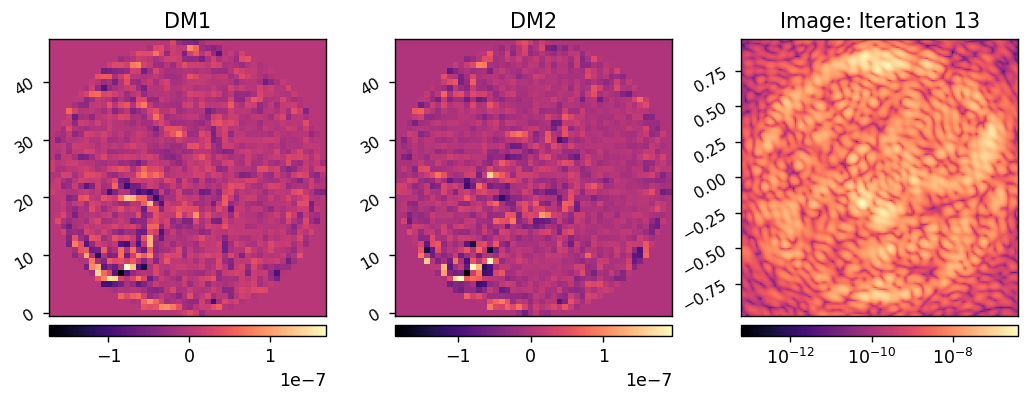

	Closed-loop iteration 14 / 20


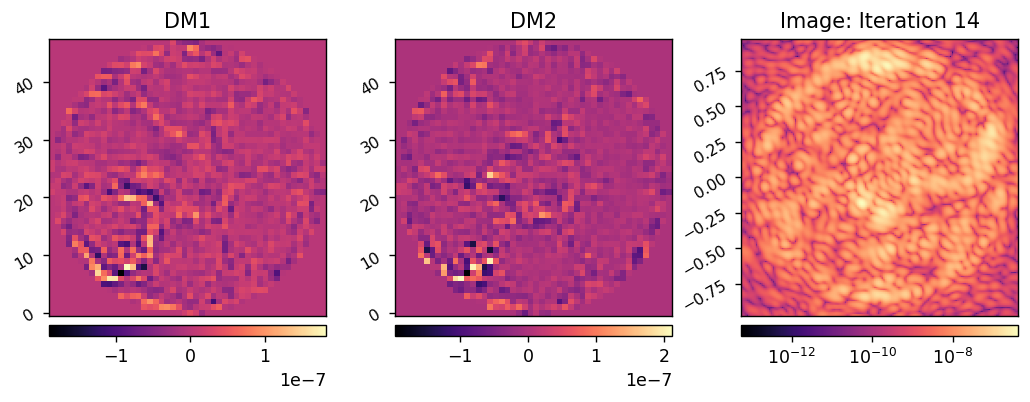

	Closed-loop iteration 15 / 20


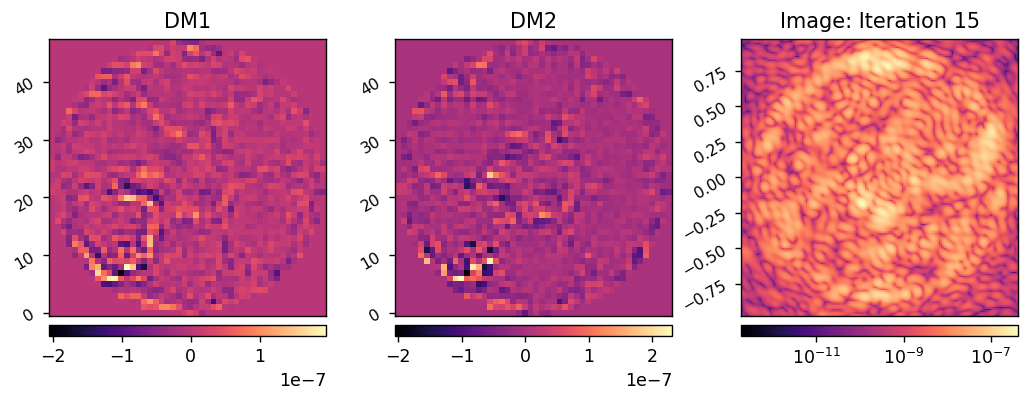

	Closed-loop iteration 16 / 20


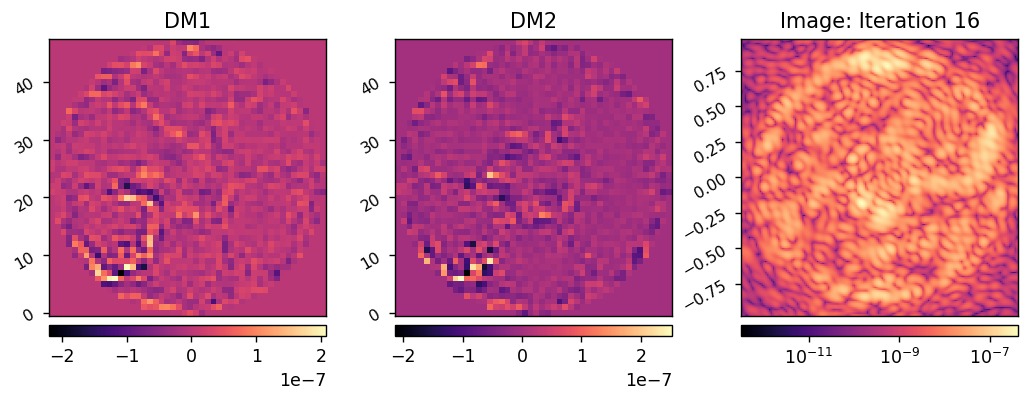

	Closed-loop iteration 17 / 20


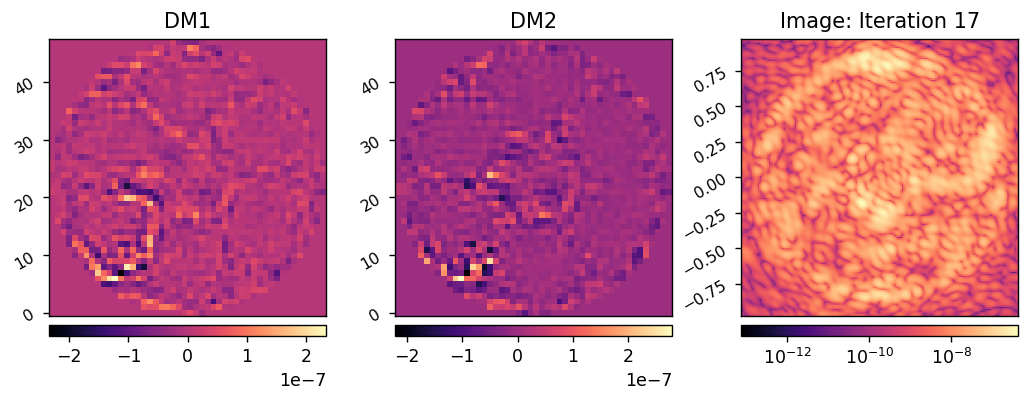

	Closed-loop iteration 18 / 20


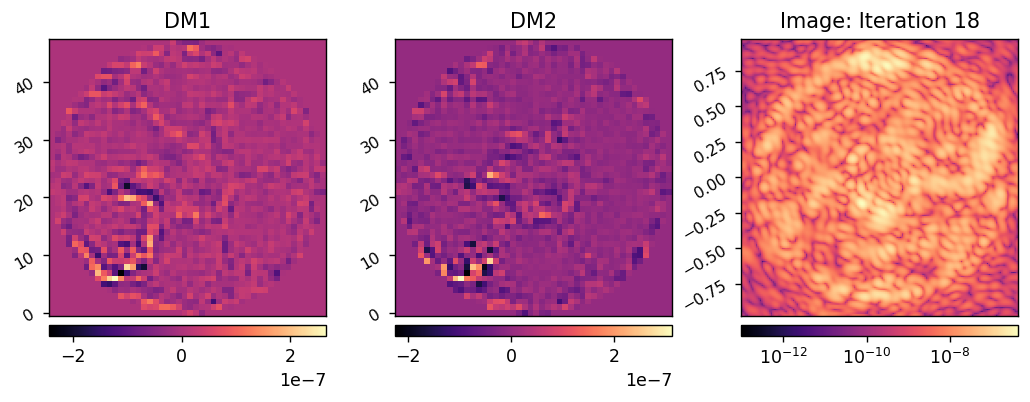

	Closed-loop iteration 19 / 20


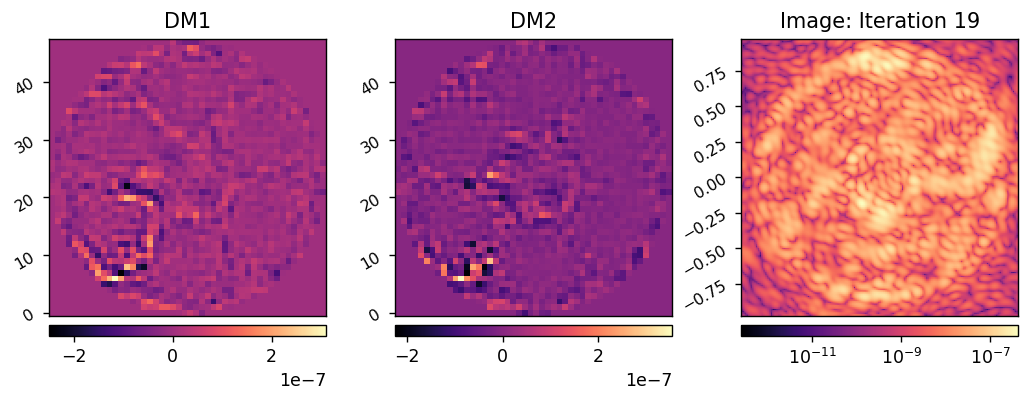

	Closed-loop iteration 20 / 20


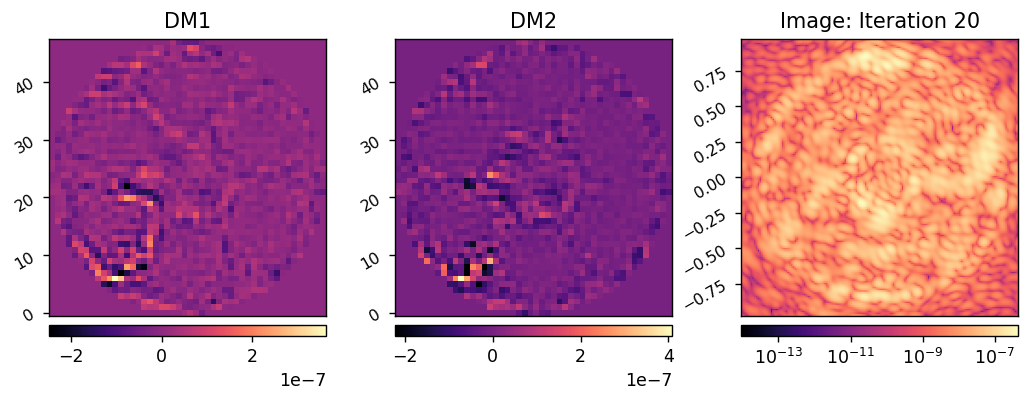

I-EFC loop completed in 45.920s.


In [11]:
reload(iefc)

sys.reset_dms()

images, dm1_commands, dm2_commands = iefc.run(sys, 
                                              control_matrix, 
                                              probe_modes, 
                                              probe_amplitude, 
                                              calibration_modes, 
                                              weights, 
                                              num_iterations=20, 
                                              gain=-0.5, leakage=0.0,
                                              display=True)

In [163]:
iefcu.save_pickle(data_dir/'image-results'/fname, images)
iefcu.save_pickle(data_dir/'dm-results'/fname, dm_commands)

Saved wavefronts to:  /groups/douglase/kians-data-files/roman-cgi-iefc-data/image-results/dshaped_Yopds_polaxis0_iwa3.0_owa6.0
Saved wavefronts to:  /groups/douglase/kians-data-files/roman-cgi-iefc-data/dm-results/dshaped_Yopds_polaxis0_iwa3.0_owa6.0
